# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [49]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [100]:
from fsds_100719.imports import *

fsds_1007219  v0.7.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [50]:
df = pd.read_csv('zillow_data.csv')

In [51]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [52]:
df.loc[df.RegionName == 95616]     # also acceptable:  df.loc[df['RegionName'] == 95616]


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
954,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0,202500.0,202500.0,...,683600,682800,679400,674400,677200,687700,696700,697500,695000,692300


# Step 2: Data Preprocessing

In [53]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [54]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

Note:  I have surmised that RegionName is the ZIP code for each entry.  RegionName values with only 4 digits represent ZIP codes that actually begin with '0'.  So that I can work with ZIP codes in the data set, I will need to add that zero onto every 4-digit RegionName value.  Once that's completed, I'll rename this column "ZipCode".  

In [55]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [56]:
# df.RegionName.sort_values().head(10)

df.sort_values(by="RegionName").head(7)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5850,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
4199,58197,1002,Amherst,MA,Springfield,Hampshire,4200,161000.0,160100.0,159300.0,...,333700,334800,336700,338900,340400,342000,344500,347400,350600,353300
11213,58200,1005,Barre,MA,Worcester,Worcester,11214,103100.0,103400.0,103600.0,...,205600,206800,208800,210400,211300,213300,215600,217900,219500,220700
6850,58201,1007,Belchertown,MA,Springfield,Hampshire,6851,133400.0,132700.0,132000.0,...,266100,266300,267000,267500,268000,268100,268100,268800,270000,270600
14547,58202,1008,Blandford,MA,Springfield,Hampden,14548,117500.0,117300.0,117100.0,...,202400,202900,205900,208500,207500,205400,204500,206800,210900,214200
11702,58204,1010,Brimfield,MA,Springfield,Hampden,11703,115800.0,115700.0,115500.0,...,246400,247500,249100,248800,245400,243800,244600,246700,248800,250900
14475,58205,1011,Chester,MA,Springfield,Hampden,14476,87000.0,87000.0,87100.0,...,160200,156700,156600,157700,155400,151400,150100,150100,149500,149100


In [57]:
df['RegionName'] = df.RegionName.astype(str)
df['RegionName'].dtype


dtype('O')

In [58]:
df.rename(columns={'RegionName': 'Zip'}, inplace=True)
df.columns
df.head()

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [59]:
zips = []

for i in df['Zip']:
    if len(i) < 5:
        i = '0' + i
        zips.append(i)
    else:
        zips.append(i)

zips
df['Zip'] = pd.Series(zips)
df.sort_values(by='Zip').head(10)


,RegionID,Zip,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5850,58196,01001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
4199,58197,01002,Amherst,MA,Springfield,Hampshire,4200,161000.0,160100.0,159300.0,...,333700,334800,336700,338900,340400,342000,344500,347400,350600,353300
11213,58200,01005,Barre,MA,Worcester,Worcester,11214,103100.0,103400.0,103600.0,...,205600,206800,208800,210400,211300,213300,215600,217900,219500,220700
6850,58201,01007,Belchertown,MA,Springfield,Hampshire,6851,133400.0,132700.0,132000.0,...,266100,266300,267000,267500,268000,268100,268100,268800,270000,270600
14547,58202,01008,Blandford,MA,Springfield,Hampden,14548,117500.0,117300.0,117100.0,...,202400,202900,205900,208500,207500,205400,204500,206800,210900,214200
11702,58204,01010,Brimfield,MA,Springfield,Hampden,11703,115800.0,115700.0,115500.0,...,246400,247500,249100,248800,245400,243800,244600,246700,248800,250900
14475,58205,01011,Chester,MA,Springfield,Hampden,14476,87000.0,87000.0,87100.0,...,160200,156700,156600,157700,155400,151400,150100,150100,149500,149100
4568,58207,01013,Chicopee,MA,Springfield,Hampden,4569,88500.0,88500.0,88400.0,...,167700,169300,171100,171900,172300,173300,174600,175900,176900,177400
2694,58209,01020,Chicopee,MA,Springfield,Hampden,2695,97200.0,97100.0,97000.0,...,178600,181000,184100,186100,186800,187400,188100,189000,189600,189800
14594,58212,01026,Cummington,MA,Springfield,Hampshire,14595,91200.0,91100.0,91000.0,...,193400,195900,200800,202600,201800,201200,204600,211200,217900,220800


In [60]:
df['Zip'] = df.Zip.astype(int)
df['Zip'].dtype

dtype('int64')

In [61]:
# The function below is from the original starter notebook. 
# I modified the function to return the entire melted df, not the 
# melted dataframe grouped by time and aggregated by mean value
# (the pd.IndexSlice method might work to resolve this issue...?)
# from JI notebook:  df = df2.loc[pd.IndexSlice[:, '2014-01-01':], :].copy()
# df.reset_index(inplace=True, level=0, drop=True)
# ts = df['value'].loc['2010':]
# ts = df.loc[df['Zip']==1267]
# ts = df.loc[df['Zip']==1267]["value"].rename(1267)
# ts = ts.resample('MS').asfreq()
# ts.plot()

# def melt_data(df):
#     melted = pd.melt(df, id_vars=['RegionID', 'Zip', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

# df_melt = melt_data(df)

In [62]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'Zip', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted   

In [63]:
df_melt = melt_data(df)

In [64]:
df_melt.head()

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [65]:
df_melt.isna().sum()

RegionID           0
Zip                0
City               0
State              0
Metro         236023
CountyName         0
SizeRank           0
time               0
value              0
dtype: int64

In [66]:
df_melt['Metro'].fillna('Missing', inplace=True)
df_melt.isna().sum()

RegionID      0
Zip           0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

In [67]:
df_melt.set_index('time', inplace=True)

In [68]:
df_melt.head()

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


In [69]:
# From James Irving's study group (one way to create a dataframe)

df_melt2 = df_melt.groupby('Zip').resample('MS').asfreq()
df_melt2

RegionID    Zip       City State        Metro  \
Zip   time                                                        
1001  1996-04-01     58196   1001     Agawam    MA  Springfield   
      1996-05-01     58196   1001     Agawam    MA  Springfield   
      1996-06-01     58196   1001     Agawam    MA  Springfield   
      1996-07-01     58196   1001     Agawam    MA  Springfield   
      1996-08-01     58196   1001     Agawam    MA  Springfield   
...                    ...    ...        ...   ...          ...   
99901 2017-12-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-01-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-02-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-03-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-04-01    100478  99901  Ketchikan    AK    Ketchikan   

                         CountyName  SizeRank     value  
Zip   time                                               
1001  1996-04-01            Hampden      5851  113100.0  
      1996-05-01            Hampden      5851  112800.0  
      1996-06-01            Hampden      5851  112600.0  
      1996-07-01            Hampden      5851  112300.0  
      1996-08-01            Hampden      5851  112100.0  
...                             ...       ...       ...  
99901 2017-12-01  Ketchikan Gateway      7294  291900.0  
      2018-01-01  Ketchikan Gateway      7294  294200.0  
      2018-02-01  Ketchikan Gateway      7294  297500.0  
      2018-03-01  Ketchikan Gateway      7294  302100.0  
      2018-04-01  Ketchikan Gateway      7294  305100.0  

[3744704 rows x 8 columns]

# Step 3: EDA and Visualization

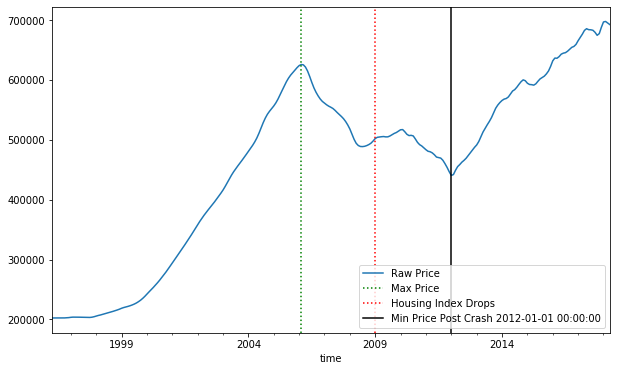

In [70]:
# Framework from James Irving's study group

ts = df_melt2['value'].loc[95616]
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()

ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()

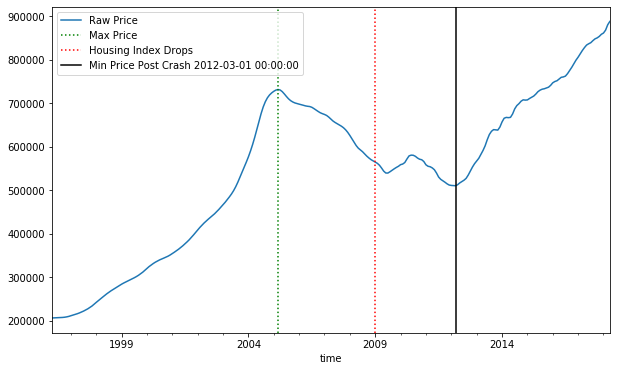

In [71]:
ts = df_melt2['value'].loc[92008]
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()

ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()


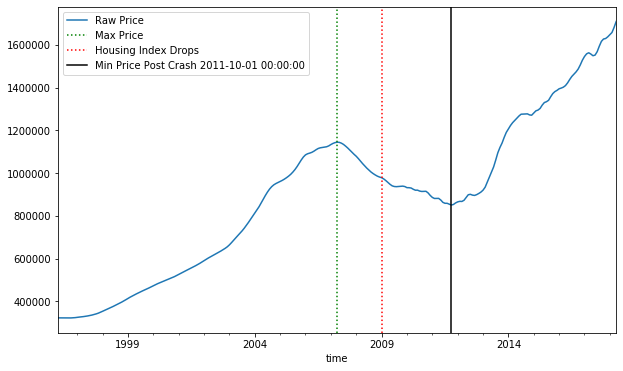

In [72]:
ts = df_melt2['value'].loc[90035]
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()

ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()


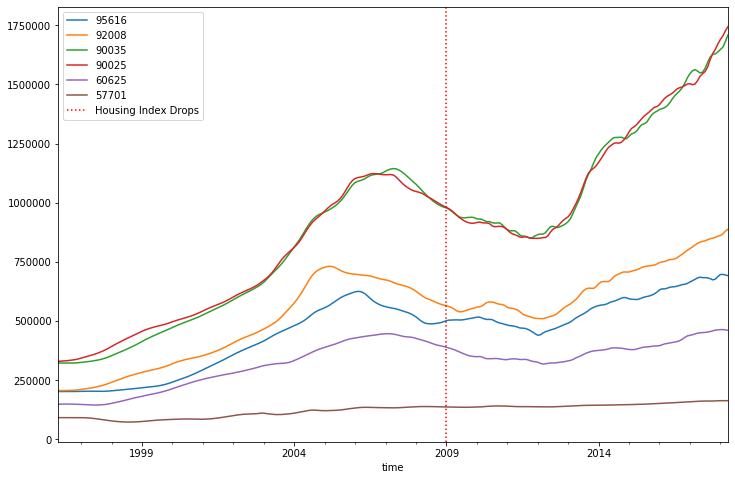

In [73]:
# Framework from James Irving's study group

def plot_ts(df_melt2, col='value', zipcodes=[95616]):
    
    fig, ax = plt.subplots()
    
    for zc in zipcodes:
        ts = df_melt2[col].loc[zc]
        ts.plot(figsize=(12, 8), label = str(zc), ax=ax)

#     max_ = ts.loc['2004':'2010'].idxmax()  # 625600
    crash = '01-2009'
#     min_ = ts.loc[crash:].idxmin()

#     ax.axvline(max_, label='Max Price', color = 'green', ls=':')
    ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
#     ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
    ax.legend()
    
    return fig, ax

fig, ax = plot_ts(df_melt2, zipcodes=[95616, 92008, 90035, 90025, 60625, 57701])


In [74]:
df_melt2.loc[95616]

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0
1996-05-01,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0
1996-06-01,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0
1996-07-01,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0
1996-08-01,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0
...,...,...,...,...,...,...,...,...
2017-12-01,98312,95616,Davis,CA,Sacramento,Yolo,955,687700.0
2018-01-01,98312,95616,Davis,CA,Sacramento,Yolo,955,696700.0
2018-02-01,98312,95616,Davis,CA,Sacramento,Yolo,955,697500.0


In [75]:
df_melt2.index

MultiIndex([( 1001, '1996-04-01'),
            ( 1001, '1996-05-01'),
            ( 1001, '1996-06-01'),
            ( 1001, '1996-07-01'),
            ( 1001, '1996-08-01'),
            ( 1001, '1996-09-01'),
            ( 1001, '1996-10-01'),
            ( 1001, '1996-11-01'),
            ( 1001, '1996-12-01'),
            ( 1001, '1997-01-01'),
            ...
            (99901, '2017-07-01'),
            (99901, '2017-08-01'),
            (99901, '2017-09-01'),
            (99901, '2017-10-01'),
            (99901, '2017-11-01'),
            (99901, '2017-12-01'),
            (99901, '2018-01-01'),
            (99901, '2018-02-01'),
            (99901, '2018-03-01'),
            (99901, '2018-04-01')],
           names=['Zip', 'time'], length=3744704)

In [76]:
df_sub = df_melt2.loc[pd.IndexSlice[:, '2014-01-01':], :].copy()
    

In [77]:
df_sub.head()

RegionID   Zip    City State        Metro CountyName  \
Zip  time                                                               
1001 2014-01-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-02-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-03-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-04-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-05-01     58196  1001  Agawam    MA  Springfield    Hampden   

                 SizeRank     value  
Zip  time                            
1001 2014-01-01      5851  185100.0  
     2014-02-01      5851  184800.0  
     2014-03-01      5851  184900.0  
     2014-04-01      5851  184500.0  
     2014-05-01      5851  184500.0

In [78]:
df_sub.index

MultiIndex([( 1001, '2014-01-01'),
            ( 1001, '2014-02-01'),
            ( 1001, '2014-03-01'),
            ( 1001, '2014-04-01'),
            ( 1001, '2014-05-01'),
            ( 1001, '2014-06-01'),
            ( 1001, '2014-07-01'),
            ( 1001, '2014-08-01'),
            ( 1001, '2014-09-01'),
            ( 1001, '2014-10-01'),
            ...
            (99901, '2017-07-01'),
            (99901, '2017-08-01'),
            (99901, '2017-09-01'),
            (99901, '2017-10-01'),
            (99901, '2017-11-01'),
            (99901, '2017-12-01'),
            (99901, '2018-01-01'),
            (99901, '2018-02-01'),
            (99901, '2018-03-01'),
            (99901, '2018-04-01')],
           names=['Zip', 'time'], length=765260)

In [79]:
df_sub.head()

RegionID   Zip    City State        Metro CountyName  \
Zip  time                                                               
1001 2014-01-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-02-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-03-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-04-01     58196  1001  Agawam    MA  Springfield    Hampden   
     2014-05-01     58196  1001  Agawam    MA  Springfield    Hampden   

                 SizeRank     value  
Zip  time                            
1001 2014-01-01      5851  185100.0  
     2014-02-01      5851  184800.0  
     2014-03-01      5851  184900.0  
     2014-04-01      5851  184500.0  
     2014-05-01      5851  184500.0

#### Pick a subset of data and move forward with that.

For now, I'll got with my current zip code.  It will be easy to change later if needed.


In [80]:
df_sub.reset_index(inplace=True, level=0, drop=True)

In [81]:
ts = df_sub.loc[df_sub['Zip']==95616]
ts = ts['value'].rename('95616')
ts

time
2014-01-01    565600.0
2014-02-01    567900.0
2014-03-01    568900.0
2014-04-01    571500.0
2014-05-01    576600.0
2014-06-01    581400.0
2014-07-01    583700.0
2014-08-01    587700.0
2014-09-01    592500.0
2014-10-01    596900.0
2014-11-01    600000.0
2014-12-01    598600.0
2015-01-01    594400.0
2015-02-01    592300.0
2015-03-01    592000.0
2015-04-01    591200.0
2015-05-01    593400.0
2015-06-01    597700.0
2015-07-01    601600.0
2015-08-01    603900.0
2015-09-01    606200.0
2015-10-01    610000.0
2015-11-01    614900.0
2015-12-01    622600.0
2016-01-01    631800.0
2016-02-01    636400.0
2016-03-01    636100.0
2016-04-01    638800.0
2016-05-01    642900.0
2016-06-01    644600.0
2016-07-01    645400.0
2016-08-01    647800.0
2016-09-01    651100.0
2016-10-01    654300.0
2016-11-01    655800.0
2016-12-01    659200.0
2017-01-01    665400.0
2017-02-01    670700.0
2017-03-01    676300.0
2017-04-01    682600.0
2017-05-01    685400.0
2017-06-01    683800.0
2017-07-01    683600.0
2017-0

In [82]:
ts = ts.resample('MS').asfreq()

In [83]:
ts.head()

time
2014-01-01    565600.0
2014-02-01    567900.0
2014-03-01    568900.0
2014-04-01    571500.0
2014-05-01    576600.0
Freq: MS, Name: 95616, dtype: float64

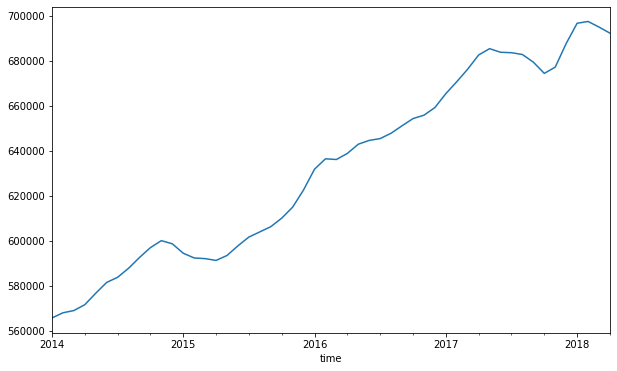

In [84]:
ts.plot(figsize=(10, 6))

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

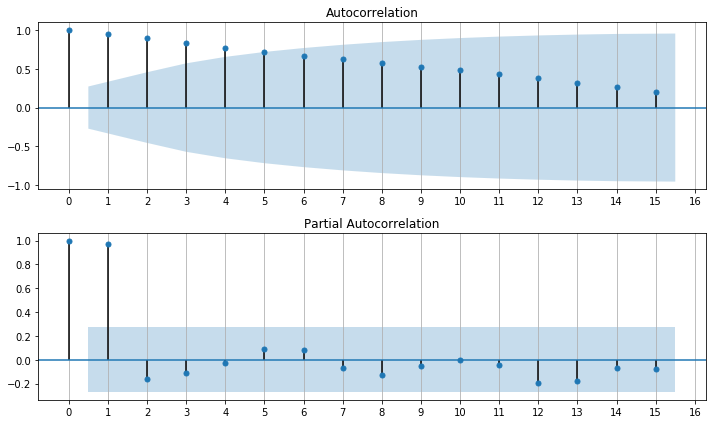

In [86]:
def plot_acf_pacf(ts, figsize=(10,6), lags=15):
    fig, ax = plt.subplots(nrows=2, figsize=figsize)
    plot_acf(ts, ax=ax[0], lags=lags)
    plot_pacf(ts, ax=ax[1], lags=lags)
    plt.tight_layout()
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    
plot_acf_pacf(ts)

Text(0.5, 1.0, 'Season Length = 365 days 00:00:00')

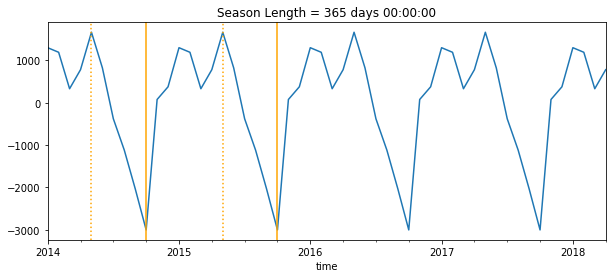

In [87]:
decomp = seasonal_decompose(ts)
ts_seasonal = decomp.seasonal

ax = ts_seasonal.plot()
fig = ax.get_figure()
fig.set_size_inches(10,4)

min_ = ts_seasonal.idxmin()
max_ = ts_seasonal.idxmax()
max_2 = ts_seasonal.loc[min_:].idxmax()
min_2 = ts_seasonal.loc[max_2:].idxmin()


ax.axvline(min_, label=min_, c='orange')
ax.axvline(max_, c='orange', ls=':')
ax.axvline(min_2, c='orange')
ax.axvline(max_2, c='orange', ls=':')

period = min_2 - min_ 
ax.set_title(f'Season Length = {period}')

# Step 5:  ARIMA Modeling

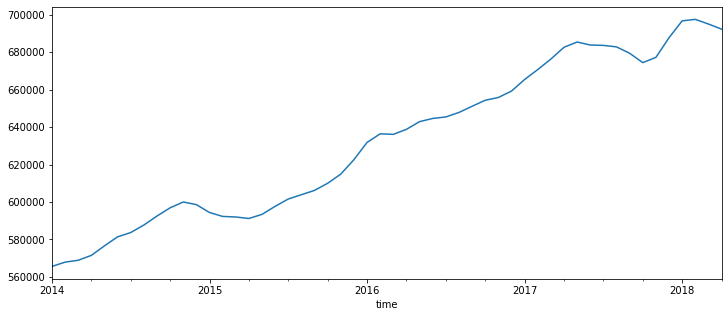

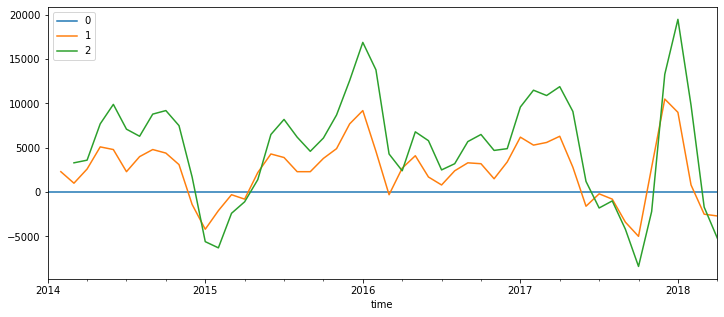

In [88]:
mpl.rcParams['figure.figsize']=(12, 5)
ts.plot()
plt.figure()

for i in range(3):
    ax = ts.diff(i).plot(label = i)
#     ax.set

plt.legend()

In [89]:
import itertools

p_range = range(0, 10)
q_range = range(0, 10)
d_range = range(1, 3)
m_range = (0, 6, 12)

pdq = list(itertools.product(p_range, d_range, q_range))
PDQM = list(itertools.product(p_range, d_range, q_range, m_range))
PDQM[:10]

[(0, 1, 0, 0),
 (0, 1, 0, 6),
 (0, 1, 0, 12),
 (0, 1, 1, 0),
 (0, 1, 1, 6),
 (0, 1, 1, 12),
 (0, 1, 2, 0),
 (0, 1, 2, 6),
 (0, 1, 2, 12),
 (0, 1, 3, 0)]

In [103]:
def make_pdq_pdqm(p_range=(0,4), d_range=(0,3), q_range=(0,4), make_seasonal=True,
                  m_values=(0,12)):
    import itertools
    ps =range(p_range[0],p_range[1])
    ds =range(d_range[0],d_range[1])
    qs =range(q_range[0],q_range[1])
    
    params = {}
    params['pdq'] = list(itertools.product(ps,ds,qs))
    
    if make_seasonal:
        params['PDQm'] = list(itertools.product(ps,ds,qs,m_values))
    return params

params = make_pdq_pdqm()
print(params.keys())
print(params['pdq'][:10])
params['PDQm'][:10]
    

dict_keys(['pdq', 'PDQm'])
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1)]


[(0, 0, 0, 0),
 (0, 0, 0, 12),
 (0, 0, 1, 0),
 (0, 0, 1, 12),
 (0, 0, 2, 0),
 (0, 0, 2, 12),
 (0, 0, 3, 0),
 (0, 0, 3, 12),
 (0, 1, 0, 0),
 (0, 1, 0, 12)]

In [104]:
def get_train_test_split_index(ts, TEST_SIZE=0.1,min_test_ts=2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    
    num_test_ts=len(ts.iloc[idx_split:])
    if num_test_ts<min_test_ts:
        print(f'[!] Warning: using TEST_SIZE={TEST_SIZE} produced {num_test_ts} test timestamps.')
        print("- Overriding TEST_SIZE and using min_test_ts instead.")
        idx_split = len(ts)-min_test_ts
    
    return idx_split

def train_test_split_ts(ts, TEST_SIZE = 0.2, min_test_ts = 2):
    idx_split = get_train_test_split_index(ts, TEST_SIZE = TEST_SIZE, min_test_ts = min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test


In [105]:
ts_train, ts_test = train_test_split_ts(ts)
len(ts_train), len(ts_test)

(41, 11)

In [106]:
def get_now(return_dt = True, return_str=True, show=False):
    import datetime as dt
    import tzlocal as tz
    now=dt.datetime.now(tz=tz.get_localzone())
    str_time =now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
    
    output=[]
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
    return output[:]


In [107]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search_sarimax(ts_train,pdq=None,pdqm=None,order_dict=None,
                        verbose=False, model_kws={}):

    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq= order_dict['pdq']
    if (pdqm is None) & (order_dict is not None):
        pdqm= order_dict['PDQm']

#     import tqdm
#     from tqdm import trange

    start,start_str = get_now(return_dt=True, return_str=True)
    print(f'[i] STARTING GRID SEARCH @ {start_str}:')

    res = [['pdq','PDQM','AIC']]
    for i in trange((len(pdq))):
        comb = pdq[i]
        
        for combs in pdqm:
            try: 
                model = SARIMAX(ts_train, order=comb, 
                               seasonal_orde =combs,enforce_stationarity=False,
                               enforce_invertibility=False,**model_kws)
                
                output= model.fit()
                res.append([comb,combs,output.aic])
            except:
                if verbose:
                    print(f"[!] Error running ({comb})({combs})")
                continue
    end,end_str = get_now(return_dt=True, return_str=True)
    elapsed = end-start
    print(f"[i] GRID SEARCH FINISHED AT {end_str}")
    print(f"\tTotal Time: {elapsed}")

    try:
        df_res =fs.list2df(res)
        return df_res
    
    except:
        print('Error converting to df. Returning as list.')
        return res 
    

In [108]:
res = grid_search_sarimax(ts_train, order_dict=params) #pdq, pdqm

  0%|          | 0/48 [00:00<?, ?it/s]

[i] STARTING GRID SEARCH @ 02/02/2020 - 09:53:47 AM:


100%|██████████| 48/48 [05:21<00:00,  6.71s/it]

[i] GRID SEARCH FINISHED AT 02/02/2020 - 09:59:09 AM
	Total Time: 0:05:21.989404


In [102]:
## Project Notebook Settings
pd.set_option('display.max_columns',0)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-notebook')

# Step 6: Interpreting Results